#  FrozenLake
Today you are going to learn how to survive walking over the (virtual) frozen lake through discrete optimization.

<img src="http://vignette2.wikia.nocookie.net/riseoftheguardians/images/4/4c/Jack's_little_sister_on_the_ice.jpg/revision/latest?cb=20141218030206" alt="a random image to attract attention" style="width: 400px;"/>


In [1]:
import gym

#create a single game instance
env = gym.make("FrozenLake-v0")

#start new game
env.reset();

[2017-08-20 11:53:18,579] Making new env: FrozenLake-v0


In [2]:
# display the game state
env.render()


SFFF
FHFH
FFFH
HFFG


### legend

![img](https://cdn-images-1.medium.com/max/800/1*MCjDzR-wfMMkS0rPqXSmKw.png)

### Gym interface

The three main methods of an environment are
* __reset()__ - reset environment to initial state, _return first observation_
* __render()__ - show current environment state (a more colorful version :) )
* __step(a)__ - commit action __a__ and return (new observation, reward, is done, info)
 * _new observation_ - an observation right after commiting the action __a__
 * _reward_ - a number representing your reward for commiting action __a__
 * _is done_ - True if the MDP has just finished, False if still in progress
 * _info_ - some auxilary stuff about what just happened. Ignore it for now

In [3]:
print("initial observation code:", env.reset())
print('printing observation:')
env.render()
print("observations:", env.observation_space, 'n=', env.observation_space.n)
print("actions:", env.action_space, 'n=', env.action_space.n)

initial observation code: 0
printing observation:

SFFF
FHFH
FFFH
HFFG
observations: Discrete(16) n= 16
actions: Discrete(4) n= 4


In [4]:
print("taking action 2 (right)")
new_obs, reward, is_done, _ = env.step(2)
print("new observation code:", new_obs)
print("reward:", reward)
print("is game over?:", is_done)
print("printing new state:")
env.render()

taking action 2 (right)
new observation code: 0
reward: 0.0
is game over?: False
printing new state:
  (Right)
SFFF
FHFH
FFFH
HFFG


In [5]:
action_to_i = {
    'left':0,
    'down':1,
    'right':2,
    'up':3
}

### Play with it
* Try walking 5 steps without falling to the (H)ole
 * Bonus quest - get to the (G)oal
* Sometimes your actions will not be executed properly due to slipping over ice
* If you fall, call __env.reset()__ to restart

In [6]:
env.reset()
env.step(action_to_i['up'])
env.render()
env.step(action_to_i['down'])
env.render()
env.step(action_to_i['down'])
env.render()
env.step(action_to_i['right'])
env.render()
env.step(action_to_i['right'])
env.render()

  (Up)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG


### Baseline: random search (2 points)

### Policy

* The environment has a 4x4 grid of states (16 total), they are indexed from 0 to 15
* From each states there are 4 actions (left,down,right,up), indexed from 0 to 3

We need to define agent's policy of picking actions given states. Since we have only 16 disttinct states and 4 actions, we can just store the action for each state in an array.

This basically means that any array of 16 integers from 0 to 3 makes a policy.

In [7]:
import numpy as np
n_states = env.observation_space.n
n_actions = env.action_space.n
def get_random_policy():
    """
    Build a numpy array representing agent policy.
    This array must have one element per each of 16 environment states.
    Element must be an integer from 0 to 3, representing action
    to take from that state.
    """
    return np.random.randint(n_actions, size=[n_states])

In [8]:
np.random.seed(1234)
policies = [get_random_policy() for i in range(10**4)]
assert all([len(p) == n_states for p in policies]), 'policy length should always be 16'
assert np.min(policies) == 0, 'minimal action id should be 0'
assert np.max(policies) == n_actions-1, 'maximal action id should match n_actions-1'
action_probas = np.unique(policies, return_counts=True)[-1] /10**4. /n_states
print("Action frequencies over 10^4 samples:",action_probas)
assert np.allclose(action_probas, [1. / n_actions] * n_actions, atol=0.05), "The policies aren't uniformly random (maybe it's just an extremely bad luck)"
print("Seems fine!")

Action frequencies over 10^4 samples: [ 0.25014375  0.25130625  0.2495375   0.2490125 ]
Seems fine!


### Let's evaluate!
* Implement a simple function that runs one game and returns the total reward

In [9]:
def sample_reward(env, policy, t_max=100):
    """
    Interact with an environment, return sum of all rewards.
    If game doesn't end on t_max (e.g. agent walks into a wall), 
    force end the game and return whatever reward you got so far.
    Tip: see signature of env.step(...) method above.
    """
    s = env.reset()
    total_reward = 0
    step_counter = 0
    
    for action in policy:
        next_state, reward, done, _ = env.step(action)
        total_reward = total_reward + reward
        step_counter = step_counter + 1
        if step_counter==t_max:
            break
    return total_reward

In [10]:
print("generating 10^3 sessions...")
rewards = [sample_reward(env,get_random_policy()) for _ in range(10**3)]
assert all([type(r) in (int, float) for r in rewards]), 'sample_reward must return a single number'
assert all([0 <= r <= 1 for r in rewards]), 'total rewards should be between 0 and 1 for frozenlake (if solving taxi, delete this line)'
print("Looks good!")

generating 10^3 sessions...
Looks good!


In [11]:
def evaluate(policy, n_times=100):
    """Run several evaluations and average the score the policy gets."""
    rewards = [sample_reward(env, policy) for i in range(n_times)]
    return float(np.mean(rewards))        

In [12]:
print(evaluate(get_random_policy()))

0.02


In [13]:
def print_policy(policy):
    """a function that displays a policy in a human-readable way."""
    lake = "SFFFFHFHFFFHHFFG"
    assert env.spec.id == "FrozenLake-v0", "this function only works with frozenlake 4x4"

    
    # where to move from each tile (we're a bit unsure if this is accurate)
    arrows = ['>^v<'[a] for a in policy]
    
    #draw arrows above S and F only
    signs = [arrow if tile in "SF" else tile for arrow, tile in zip(arrows, lake)]
    
    for i in range(0, 16, 4):
        print(' '.join(signs[i:i+4]))

print("random policy:")
print_policy(get_random_policy())

random policy:
v ^ v v
> H < H
< > ^ H
H > > G


### Main loop

In [14]:
best_policy = None
best_score = -float('inf')

from tqdm import tqdm
for i in tqdm(range(10000)):
    policy = get_random_policy()
    score = evaluate(policy)
    if score > best_score:
        best_score = score
        best_policy = policy
        print("New best score:", score)
        print("Best policy:")
        print_policy(best_policy)

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

New best score: 0.01
Best policy:
v > > v
> H < H
^ > > H
H v < G


  0%|                                                                                | 4/10000 [00:00<04:43, 35.29it/s]

New best score: 0.02
Best policy:
^ > < ^
v H ^ H
^ ^ < H
H ^ ^ G


  0%|                                                                                | 8/10000 [00:00<04:46, 34.84it/s]

New best score: 0.04
Best policy:
> < < ^
< H < H
^ > v H
H < < G


  1%|▊                                                                             | 111/10000 [00:02<03:24, 48.40it/s]

New best score: 0.05
Best policy:
v v v v
v H < H
^ > v H
H < v G


  3%|██▏                                                                           | 288/10000 [00:05<03:18, 48.96it/s]

New best score: 0.06
Best policy:
^ v v ^
v H ^ H
v < ^ H
H > ^ G


  8%|██████                                                                        | 785/10000 [00:16<03:00, 51.19it/s]

New best score: 0.07
Best policy:
^ > v v
v H v H
^ v v H
H v ^ G


 12%|█████████▌                                                                   | 1246/10000 [00:25<02:51, 51.04it/s]

New best score: 0.08
Best policy:
< ^ > ^
v H > H
v ^ v H
H < ^ G


 75%|█████████████████████████████████████████████████████████▉                   | 7521/10000 [02:30<00:51, 47.86it/s]

New best score: 0.09
Best policy:
> > ^ ^
< H < H
^ v v H
H ^ v G


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:21<00:00, 49.70it/s]


# Part II Genetic algorithm (4 points)

The next task is to devise some more effecient way to perform policy search.
We'll do that with a bare-bones evolutionary algorithm.
[unless you're feeling masochistic and wish to do something entirely different which is bonus points if it works]

In [50]:
def crossover(policy1, policy2, p=0.5):
    """
    for each state, with probability p take action from policy1, else policy2
    """
    if np.random.random() > 0.5:
        offspring = np.concatenate((policy1[0:int(n_states/2)], policy2[int(n_states/2):]))
    else:
        offspring = np.concatenate((policy2[0:int(n_states/2)], policy1[int(n_states/2):]))
    return offspring

In [51]:
# roughwork
test_policy1 = get_random_policy()
test_policy2 = get_random_policy()
print(test_policy1)
print(test_policy2)
print(crossover(test_policy1, test_policy2))

[1 0 0 2 2 3 3 2 0 3 3 3 1 2 2 1]
[1 0 2 2 1 2 3 3 3 2 2 0 2 1 1 3]
[1 0 0 2 2 3 3 2 3 2 2 0 2 1 1 3]


In [52]:
def mutation(policy, p=0.1):
    """
    for each state, with probability p replace action with random action
    Tip: mutation can be written as crossover with random policy
    """
    return crossover(policy, get_random_policy(), 0.1)
    

In [53]:
test_policy1 = get_random_policy()
print(test_policy1)
print(mutation(test_policy1))

[1 2 0 1 2 3 2 3 1 0 1 3 0 0 1 3]
[1 2 0 1 2 3 2 3 3 2 2 3 2 1 2 1]


In [54]:
np.random.seed(1234)
policies = [crossover(get_random_policy(), get_random_policy()) 
            for i in range(10**4)]

assert all([len(p) == n_states for p in policies]), 'policy length should always be 16'
assert np.min(policies) == 0, 'minimal action id should be 0'
assert np.max(policies) == n_actions-1, 'maximal action id should be n_actions-1'

assert any([np.mean(crossover(np.zeros(n_states), np.ones(n_states))) not in (0, 1)
               for _ in range(100)]), "Make sure your crossover changes each action independently"
print("Seems fine!")

Seems fine!


In [131]:

n_epochs = 100 #how many cycles to make
pool_size = 200 #how many policies to maintain
n_crossovers = 100 #how many crossovers to make on each step
n_mutations = 100 #how many mutations to make on each tick


In [132]:
print("initializing...")
pool = [get_random_policy() for i in range(pool_size)]
pool_scores = [evaluate(policy) for policy in pool]
print("complete...")

initializing...
complete...


In [133]:
assert type(pool) == type(pool_scores) == list
assert len(pool) == len(pool_scores) == pool_size
assert all([type(score) in (float, int) for score in pool_scores])


In [134]:
# roughwork
crossover_index = np.random.choice(len(pool),n_crossovers * 2,replace=True)
print(len([crossover(pool[i],pool[k]) for i,k in zip(crossover_index[0::2], crossover_index[1::2])]))
mutation_index = np.random.choice(len(pool),n_mutations,replace=True)
print(len([mutation(pool[i]) for i in mutation_index]))

100
100


In [135]:
#main loop
#improvement visualization
epoch_scores = []

for epoch in range(n_epochs):
    print("Epoch %s:"%epoch)
    
    # crossover with no priority
    # crossover_index = np.random.choice(len(pool),n_crossovers * 2,replace=True)
    
    # prioritize crossover for higher-scorers
    crossover_index = np.random.randint(int(len(pool)/3),len(pool),n_crossovers)
    
    mutation_index = np.random.choice(len(pool),n_mutations,replace=True)
    
    crossovered = [crossover(pool[i],pool[k]) for i,k in zip(crossover_index[0::2], crossover_index[1::2])]
    mutated = [mutation(pool[i]) for i in mutation_index]
    
    assert type(crossovered) == type(mutated) == list
    
    #add new policies to the pool
    pool = pool + crossovered + mutated
    pool_scores = [evaluate(policy) for policy in pool]
    
    #select pool_size best policies
    selected_indices = np.argsort(pool_scores)[-pool_size:]
    pool = [pool[i] for i in selected_indices]
    pool_scores = [pool_scores[i] for i in selected_indices]

    #print the best policy so far (last in ascending score order)
    print("best score:", pool_scores[-1])
    epoch_scores.append(pool_scores[-1])
    print_policy(pool[-1])

Epoch 0:
best score: 0.06
> < v ^
^ H v H
^ ^ ^ H
H v < G
Epoch 1:
best score: 0.06
^ ^ ^ >
> H ^ H
^ v ^ H
H v ^ G
Epoch 2:
best score: 0.07
^ v ^ ^
v H ^ H
v v ^ H
H > > G
Epoch 3:
best score: 0.06
^ v ^ ^
v H ^ H
^ ^ ^ H
H > > G
Epoch 4:
best score: 0.08
^ ^ ^ >
> H ^ H
^ v ^ H
H v ^ G
Epoch 5:
best score: 0.07
v > ^ ^
v H ^ H
^ > < H
H > > G
Epoch 6:
best score: 0.07
> > > v
> H ^ H
^ v ^ H
H v ^ G
Epoch 7:
best score: 0.07
> ^ > v
v H ^ H
^ v ^ H
H v ^ G
Epoch 8:
best score: 0.07
> v v v
v H v H
> v ^ H
H < ^ G
Epoch 9:
best score: 0.08
< v < <
v H v H
v > ^ H
H < > G
Epoch 10:
best score: 0.09
< > > v
v H ^ H
^ ^ v H
H ^ v G
Epoch 11:
best score: 0.11
> ^ v v
^ H v H
^ v ^ H
H v ^ G
Epoch 12:
best score: 0.09
> ^ > ^
> H v H
^ v ^ H
H v ^ G
Epoch 13:
best score: 0.1
v > ^ ^
v H ^ H
^ ^ v H
H ^ v G
Epoch 14:
best score: 0.08
v > > ^
^ H ^ H
^ ^ v H
H < > G
Epoch 15:
best score: 0.09
v > ^ ^
v H ^ H
^ v ^ H
H v ^ G
Epoch 16:
best score: 0.08
^ ^ ^ v
^ H ^ H
^ ^ ^ H
H ^ < G
Epoch 17

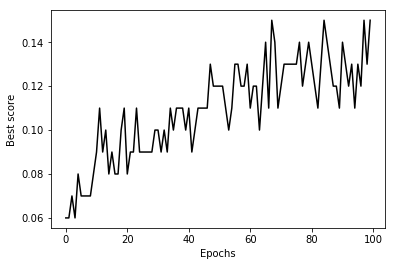

In [144]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(epoch_scores, color = 'k')
plt.ylabel('Best score')
plt.xlabel('Epochs')
plt.show()

## moar

The parameters of the genetic algorithm aren't optimal, try to find something better. (size, crossovers and mutations)

Try alternative crossover and mutation strategies
* prioritize crossover for higher-scorers?
* try to select a more diverse pool, not just best scorers?
* Just tune the f*cking probabilities.

See which combination works best!

# Part III (4 points +)

The frozenlake problem above is just too simple: you can beat it even with a random policy search. Go solve something more complicated.

Pick __one of the two tasks__:

* __FrozenLake8x8-v0__ - frozenlake big brother. Achieve score >0.7
* __Taxi-v1__ - essentially a maze where you get score for moving passengers to their destinations. Achieve score >-100)

Your homework assignment is beating that score (see tips below).


### Some tips:
* When solving those envs, please make sure your t_max is large enough to finish game with suboptimal policy. For example, __Taxi-v0 only trains if you let it play for 10k+ ticks/session__. For frozenlake8x8 it's less dire.
* Random policy search is worth trying as a sanity check, but in general you should expect the genetic algorithm (or anything you devised in it's place) to fare much better that random.
* While _it's okay to adapt the tabs above to your chosen env_, make sure you didn't hard-code any constants there (e.g. 16 states or 4 actions).
* `print_policy` function was built for the frozenlake-v0 env so it will break on any other env. You could simply ignore it or rewrite it for your env.
* in function `sample_reward`, __make sure t_max steps is enough to solve the environment__ even if agent is sometimes acting suboptimally. To estimate that, run several sessions without time limit and measure their length.

### Bonus I (2 points):
* Gym envs have a condition for "beating the game". E.g. here's the conditions for [Taxi-v1](https://gym.openai.com/envs/Taxi-v1). 
* If you managed to do that, it's worth uploading your first solution to gym. See `gym.upload(...)` docs. Allbeit it isn't a strong AI (or is it?), uploading your algorithm would be a good start. (and a +point!)
* You'll get __+1 point__ for uploading and __+1 more if you beat the game__

### Bonus II (4 points):
* There are environments with continuous state spaces. In fact, most real world environments have this property. While we will dive into methods designed for that later, right now you already can solve them through binarization.
 * Gym has a basic infinite-state-space env called [CartPole](https://gym.openai.com/envs/CartPole-v0) - please start from this one. Solving something more challenging is great, but make sure your algorithm beats cartpole first. Also kudos for submitting.
 * Main idea: if you have something infinite and you want something discrete, you split it into bins. Like what histogram does.
 * Good choice of discretes is critical!
 * If the dimensionality is too high, you can try to reduce it (PCA/autoencoders)



If you're running on a server/in binder, you may want to run this _at the very beginning of the notebook_ (before first cell imports gym):
```
#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1
```